In [1]:
import matplotlib.pyplot as plt

import numpy as np
from numpy.polynomial import Polynomial
from numsplines import AdaptiveLSQUnivariateSpline

In [2]:
table = np.genfromtxt('example.dat')
xdata = table[:, 0]
ydata = table[:, 1]

xmin = np.min(xdata)
xmax = np.max(xdata)
xplot = np.linspace(xmin, xmax, 1000)

In [3]:
# boundary fit using polynomials
def boundfit_poly(x, y, deg, boundary='upper', xi=100, niter=100):
    if boundary not in ['upper', 'lower']:
        raise SystemExit(f'Invalid boundary: {boundary}')
    flag = {'upper': 1, 'lower': -1}
    # initial fit
    poly = Polynomial.fit(x=x, y=y, deg=deg)
    # iterate to compute upper boundary
    for i in range(niter):
        residuals = y - poly(x)
        sign = np.sign(residuals).astype(int)
        w = np.ones_like(x)
        w[sign==flag[boundary]] = xi
        w[sign==0] = xi
        poly = Polynomial.fit(x=x, y=y, deg=deg, w=w)
    return poly

In [4]:
# boundary fit using splines
def boundfit_adaptive_spline(x, y, t, boundary='upper', xi=100, niter=20):
    if boundary not in ['upper', 'lower']:
        raise SystemExit(f'Invalid boundary: {boundary}')
    flag = {'upper': 1, 'lower': -1}
    # the x data must be sorted
    isort = np.argsort(x)
    x = x[isort]
    y = y[isort]
    # initial fit
    spl = AdaptiveLSQUnivariateSpline(x=x, y=y, t=t)
    # iterate to compute upper boundary
    for i in range(niter):
        residuals = y - spl(x)
        sign = np.sign(residuals).astype(int)
        w = np.ones_like(x)
        w[sign==flag[boundary]] = xi
        w[sign==0] = xi
        spl = AdaptiveLSQUnivariateSpline(x=x, y=y, w=w, t=t)
    return spl

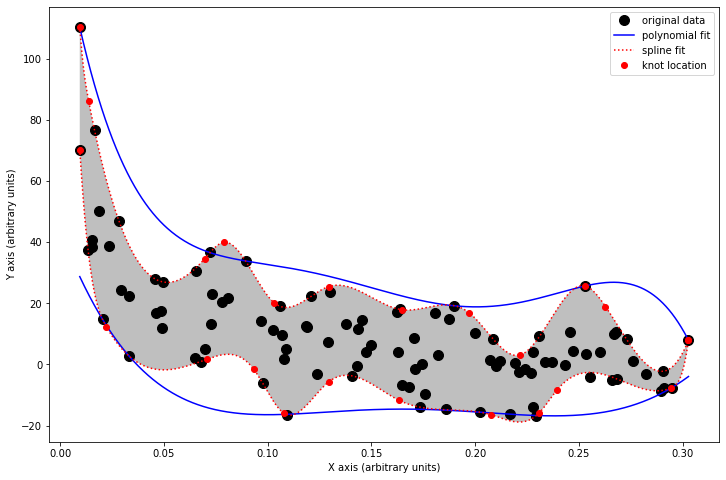

In [5]:
# reproduce example plot from Cardiel (2009)
# https://ui.adsabs.harvard.edu/abs/2009MNRAS.396..680C/abstract

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax.plot(xdata, ydata, 'ko', markersize=10, label='original data')

poly1 = boundfit_poly(x=xdata, y=ydata, deg=5, boundary='upper')
ax.plot(xplot, poly1(xplot), 'b-', label='polynomial fit')

poly2 = boundfit_poly(x=xdata, y=ydata, deg=5, boundary='lower')
ax.plot(xplot, poly2(xplot), 'b-')

spl1 = boundfit_adaptive_spline(x=xdata, y=ydata, t=10, boundary='upper')
ax.plot(xplot, spl1(xplot), 'r:', label='spline fit')
xknots = spl1.get_knots()
yknots = spl1(xknots)
ax.plot(xknots, yknots, 'r.', markersize=12, label='knot location')

spl2 = boundfit_adaptive_spline(x=xdata, y=ydata, t=10, boundary='lower')
ax.plot(xplot, spl2(xplot), 'r:')
xknots = spl2.get_knots()
yknots = spl2(xknots)
ax.plot(xknots, yknots, 'r.', markersize=12)

ax.fill_between(xplot, spl1(xplot), spl2(xplot), facecolor='grey', alpha=0.5)

ax.set_xlabel('X axis (arbitrary units)')
ax.set_ylabel('Y axis (arbitrary units)')
ax.legend()